In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
df.shape

(3276, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [6]:
df['Potability'].value_counts(normalize=True)

Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

In [7]:
df.drop('Potability', axis=1).skew()

ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
dtype: float64

In [8]:
df.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


In [9]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [10]:
# We have 3 features with the mssing values.

# ph : 491
# Sulfate : 781
# Trihalomethanes : 162

In [11]:
df.isnull().mean()*100 

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [12]:
df = pd.read_csv('water_potability.csv')
X = df.drop('Potability', axis=1)
y = df['Potability']

X_trainXG, X_testXG, y_trainXG, y_testXG = train_test_split(X, y, test_size=0.3,random_state=42)
print(f'Size of the X_train: {X_trainXG.shape[0]}')
modelXG = XGBClassifier(eval_metric='logloss')
modelXG.fit(X_trainXG, y_trainXG)
predictions = modelXG.predict(X_testXG)

accuracy = accuracy_score(y_testXG, predictions)
print (f'Accuracy:: {round(accuracy * 100.0,3)}')

Size of the X_train: 2293
Accuracy:: 65.209


In [13]:
# As we can see the Accuracy of the above model appears to be 65.209

In [14]:
missing_cols = ['ph', 'Sulfate', 'Trihalomethanes']

In [15]:
#Implementing simple imputer using the median strategy to fill in the missing Data in the table
imputer = SimpleImputer(strategy='median')

In [16]:
# Fit the SimpleImputer object to your DataFrame
imputer.fit(df[missing_cols])

SimpleImputer(strategy='median')

In [17]:
# Transform your DataFrame to impute the missing values
imputed_data = imputer.transform(df[missing_cols])

In [18]:
imputed_data

array([[  7.0367521 , 368.51644135,  86.99097046],
       [  3.71608008, 333.07354575,  56.32907628],
       [  8.09912419, 333.07354575,  66.42009251],
       ...,
       [  9.41951032, 333.07354575,  69.84540029],
       [  5.12676292, 333.07354575,  77.4882131 ],
       [  7.87467136, 333.07354575,  78.69844633]])

In [19]:
# Replace the missing values in your original DataFrame with the imputed values
df.loc[:, missing_cols] = imputed_data

In [20]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,333.073546,392.449580,19.903225,66.622485,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,333.073546,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,333.073546,402.883113,11.168946,77.488213,4.708658,1


In [21]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [22]:
df.Potability.value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

In [23]:
sns.set_style('darkgrid') # Seaborn style
pd.options.mode.copy_on_write = True
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [24]:
df.describe().loc[['min', '50%', 'mean', 'max', 'std']].T.style.background_gradient(axis=1)

,min,50%,mean,max,std
ph,0.000000,7.036752,7.074194,14.000000,1.470040
Hardness,47.432000,196.967627,196.369496,323.124000,32.879761
Solids,320.942611,20927.833607,22014.092526,61227.196008,8768.570828
Chloramines,0.352000,7.130299,7.122277,13.127000,1.583085
Sulfate,129.000000,333.073546,333.608364,481.030642,36.143851
Conductivity,181.483754,421.884968,426.205111,753.342620,80.824064
Organic_carbon,2.200000,14.218338,14.284970,28.300000,3.308162
Trihalomethanes,0.738000,66.622485,66.407478,124.000000,15.769958
Turbidity,1.450000,3.955028,3.966786,6.739000,0.780382
Potability,0.000000,0.000000,0.390110,1.000000,0.487849


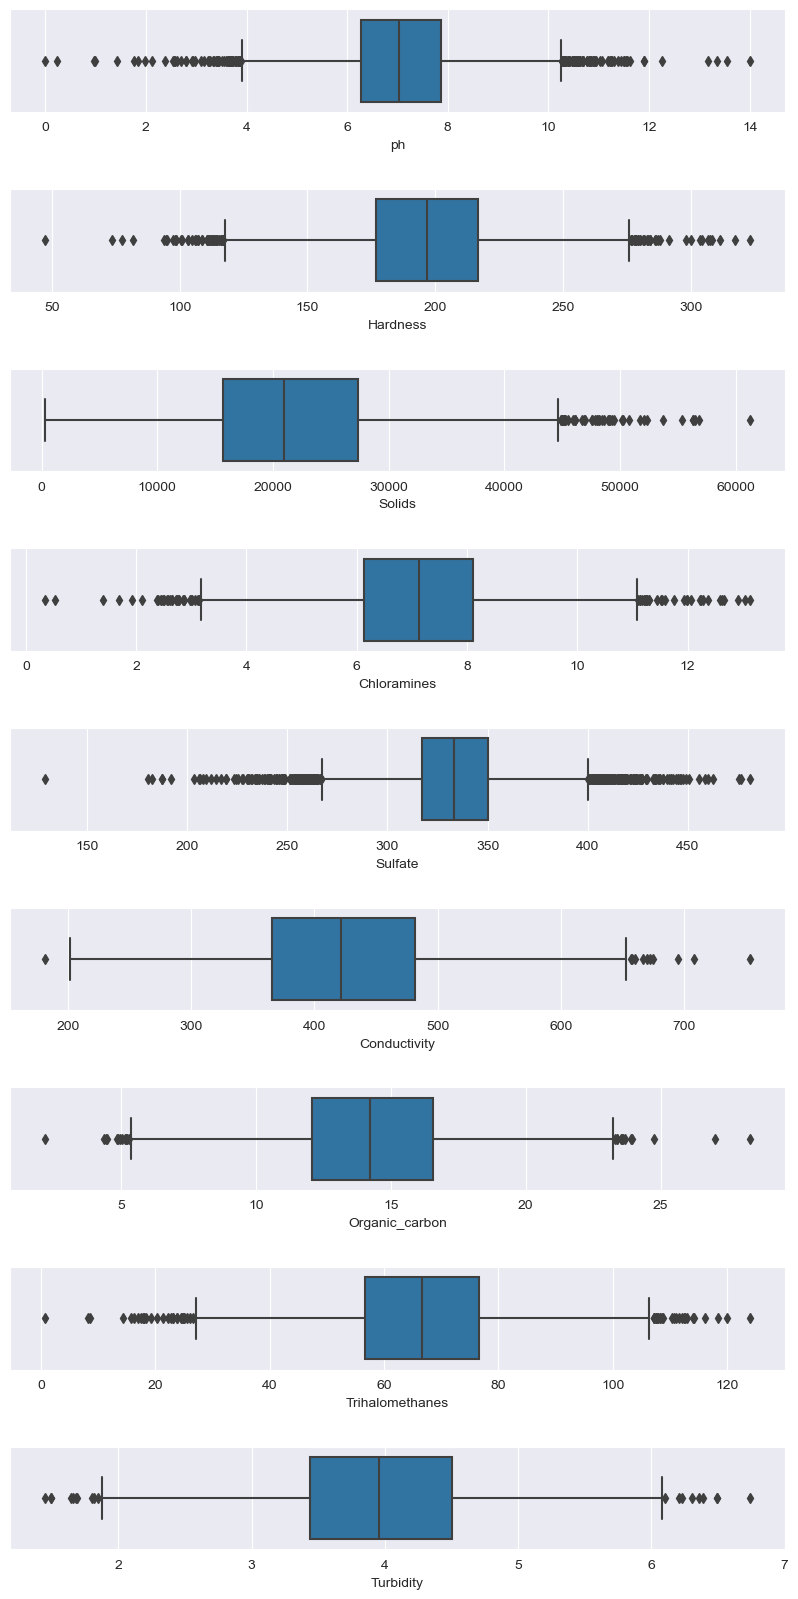

In [25]:
columns_name = df.columns
fig, ax = plt.subplots(9, 1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.75)
for i in range(9) :
    # Ax
    sns.boxplot(x=columns_name[i], data=df, ax=ax[i])

Potability
0    1998
1    1278
Name: count, dtype: int64


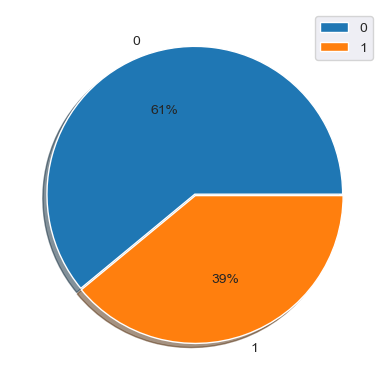

In [26]:
tar = df['Potability'].value_counts()
print(tar)

plt.pie(tar, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.show()

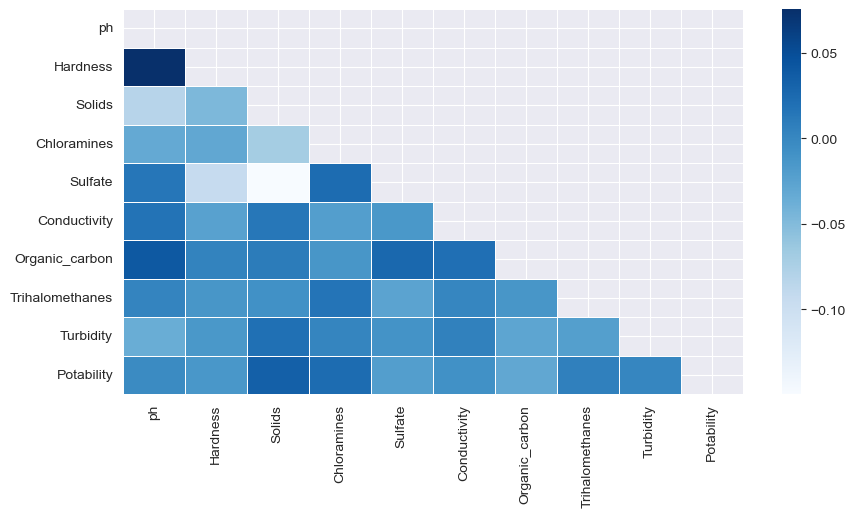

In [27]:
corr = df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5, linecolor='white', mask=np.triu(corr), cmap='Blues')
plt.show()

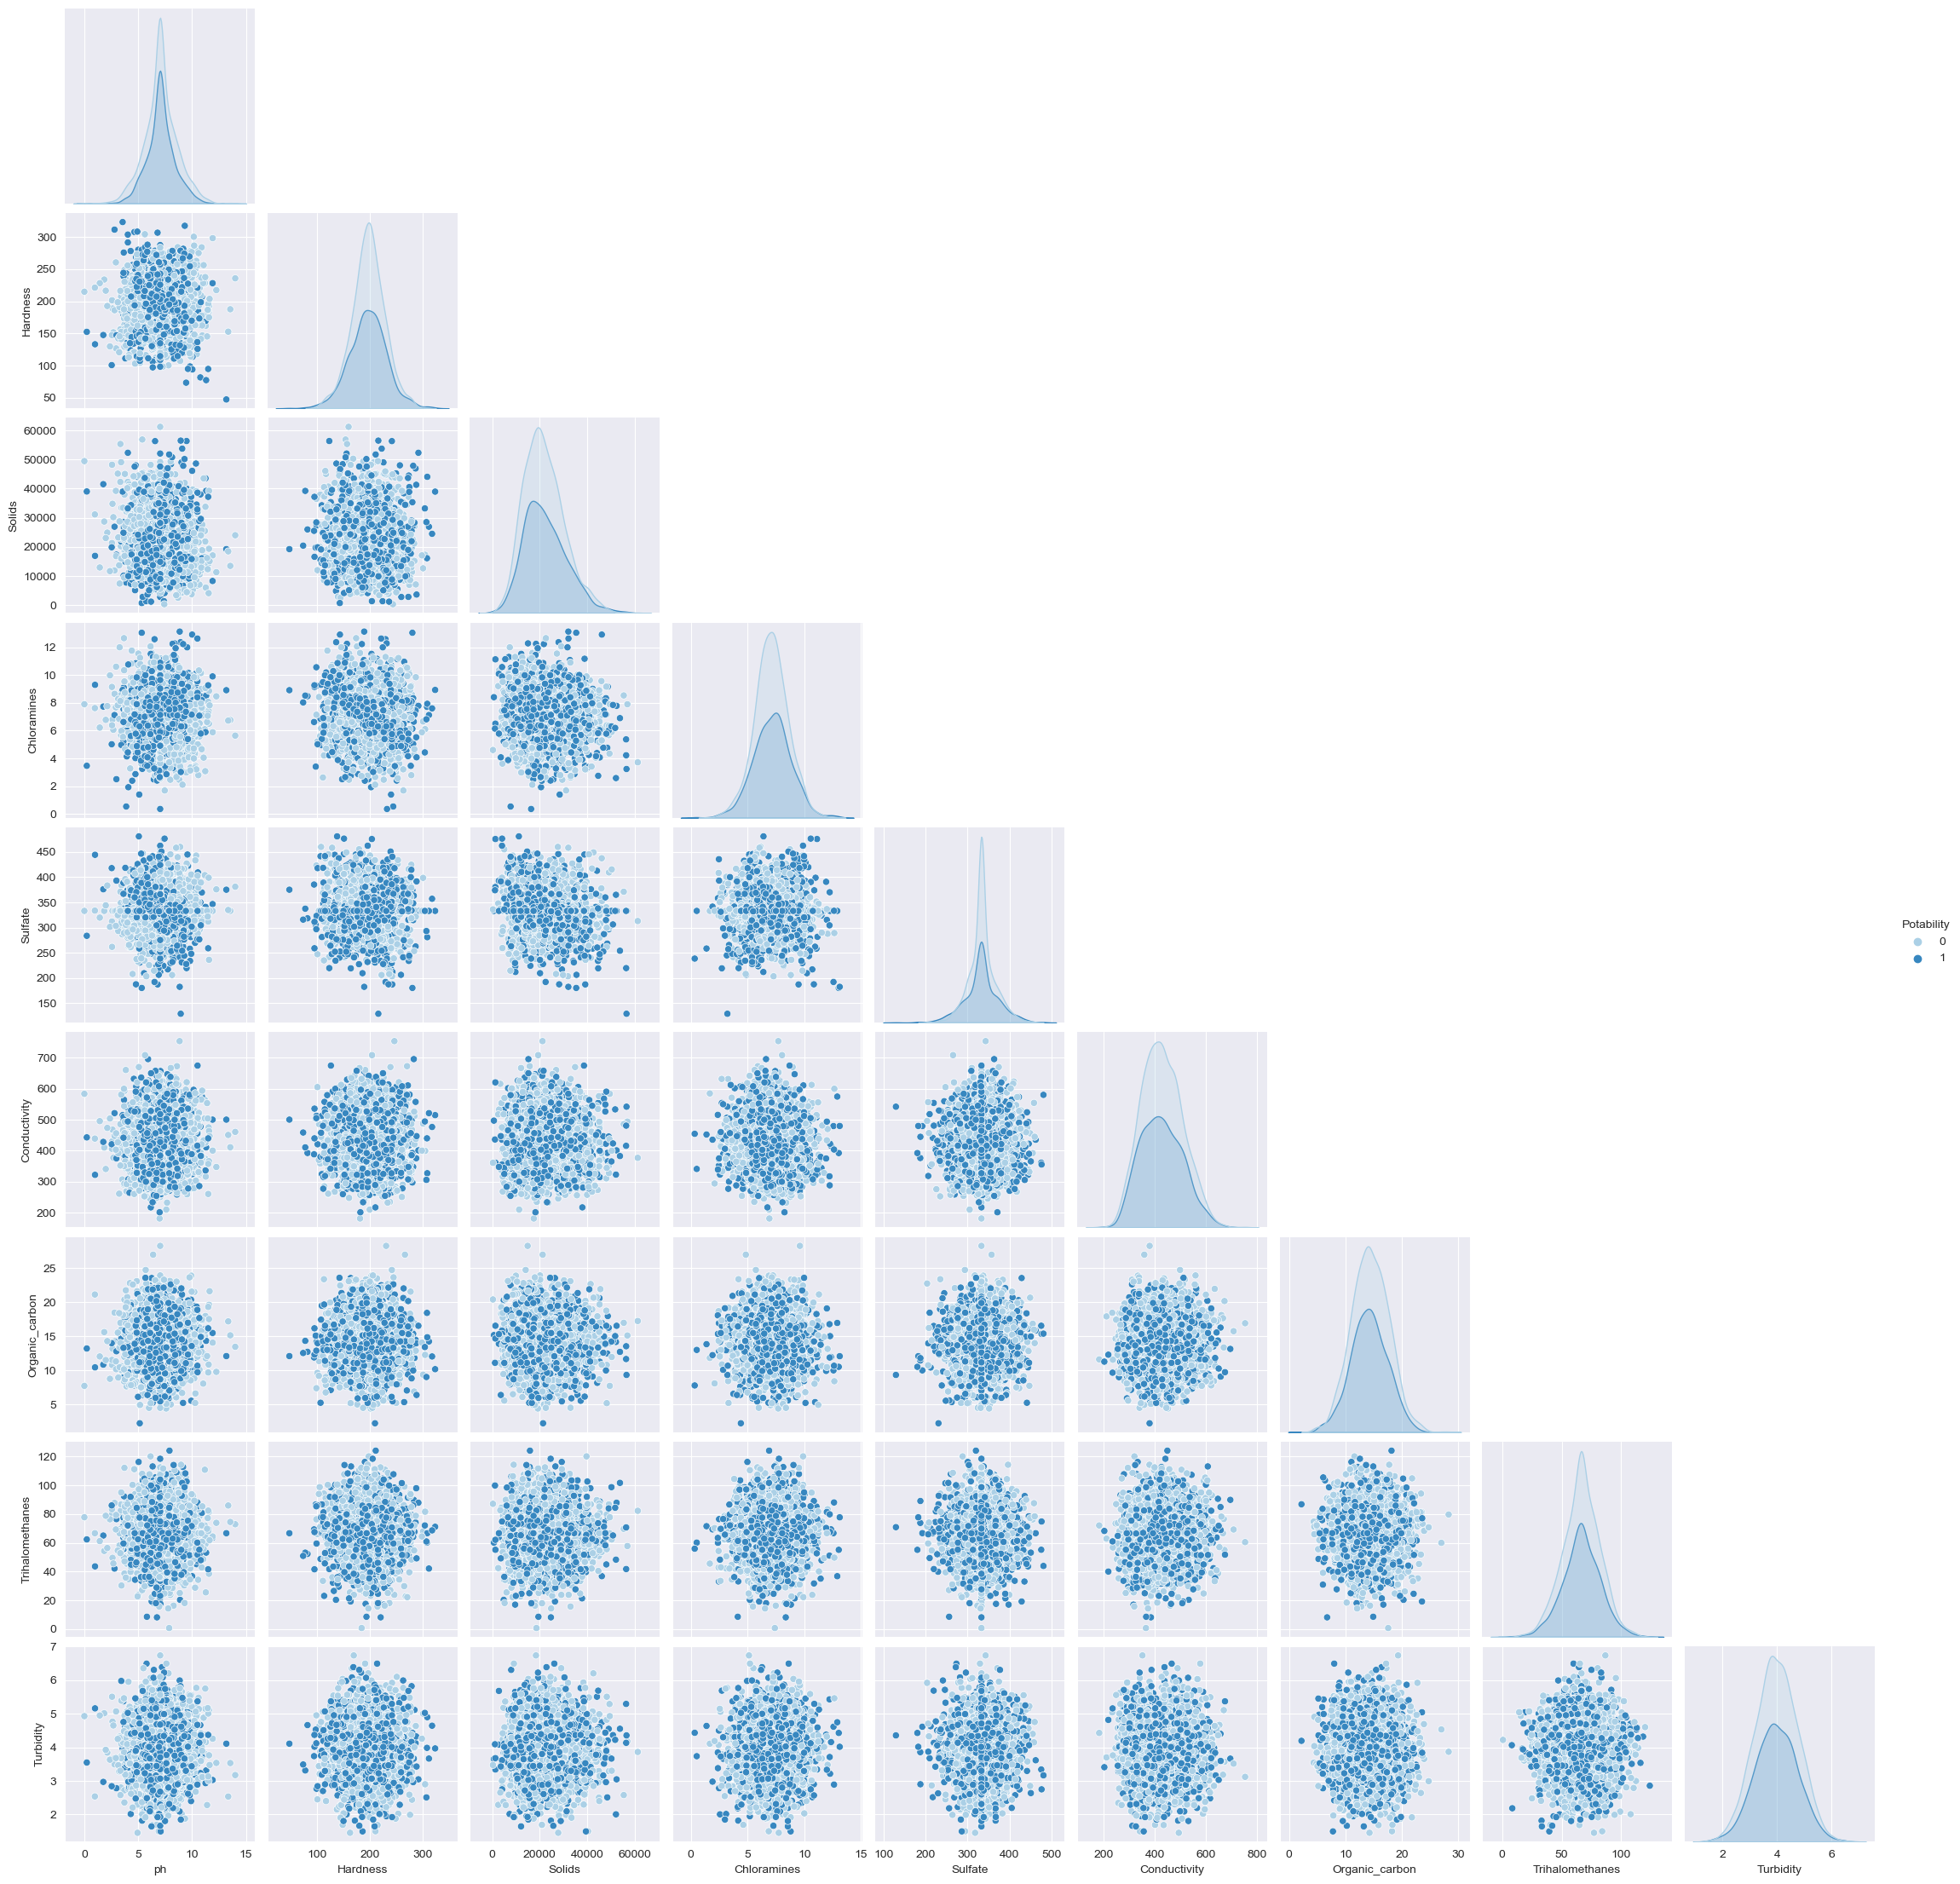

In [28]:
sns.pairplot(df, hue='Potability', corner=True, palette='Blues')
plt.show()

In [29]:
#There is no logical correlation in our data

In [30]:
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

In [34]:
# We will now perform Hyper-Parameter Tuning

In [35]:
lr = LogisticRegression()

knn = KNeighborsClassifier()


dt = DecisionTreeClassifier()

rf = RandomForestClassifier()

ada = AdaBoostClassifier()

xgb =XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)

In [36]:
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn),
               ('Decision Tree', dt), ('Random Forest', rf), ('AdaBoost', ada), ('XGBoost', xgb)]

In [37]:
# We will now check the accuracy of the models without any sort of tuning of the parameters

In [38]:
from sklearn.metrics import accuracy_score

for classifier_name, classifier in classifiers:
 
    # Fit clf to the training set
    classifier.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    

   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))

Logistic Regression : 0.61
K Nearest Neighbours : 0.65
Decision Tree : 0.60
Random Forest : 0.68
AdaBoost : 0.62
XGBoost : 0.66


In [39]:
# These are the above 6 models that we will use on our data set.

# We will now perform Hyper-Parameter tuning on each of them in order to obtain the best possible accuracy.

In [40]:
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],               # Penalty type: L1 or L2
    'solver': ['liblinear', 'saga']        # Solver algorithms
}

grid_logistic_reg = GridSearchCV(lr, param_grid, cv=5)

In [41]:
# Parameters for Logistic Regression Algorithm

# We're specifying a grid of hyperparameters to search over, including 'C' (regularization strength),
#'penalty' (type of penalty: L1 or L2), and 'solver' (solver algorithms).

In [42]:
para_knn = {'n_neighbors':np.arange(1, 50)}  #parameters of knn
grid_knn = GridSearchCV(knn, param_grid=para_knn, cv=5) #search knn for 5 fold cross validation

In [43]:
# K-Nearest Neighbor Classifier is a machine learning algorithm used for classification and regression. It works by finding the K nearest points in the training dataset and uses their class to predict the class or value of a new data point.

# We need to find the ideal value of K for the best possible accuracy.


# Larger k= less complex model = can lead to underfitting.

# Smaller k= more complex model = can lead to overfitting.

In [44]:
para_dt = {'criterion':['gini','entropy'],'max_depth':np.arange(1, 50), 'min_samples_leaf':[1,2,4,5,10,20,30,40,80,100]}
grid_dt = GridSearchCV(dt, param_grid=para_dt, cv=5) 

In [45]:
# Grid search decision tree for 5 fold cv

# "Gini" for the Gini impurity and “entropy” for the information gain.
# min_samples_leaf: The minimum number of samples required to be at a leaf node, have the effect of smoothing the model

In [46]:
params_rf = {'n_estimators':[100,200, 350, 500], 'min_samples_leaf':[2, 10, 30]}
grid_rf = GridSearchCV(rf, param_grid=params_rf, cv=5)

In [47]:
# Parameters for random forest

# Grid search decision tree for 5 fold cv
# n_estimators: The number of trees in the forest.
# min_samples_leaf: The minimum number of samples required to be at a leaf node, have the effect of smoothing the model

In [48]:
params_ada = {'n_estimators': [50,100,250,400,500,600], 'learning_rate': [0.2,0.5,0.8,1]}
grid_ada =  GridSearchCV(ada, param_grid=params_ada, cv=5)

In [49]:
# Parameters for AdaBoost

# 'n_estimators', which represents the number of estimators (or weak learners) in the ensemble
# 'learning_rate', which controls the contribution of each weak learner.

In [50]:
params_xgb = {'n_estimators': [50,100,250,400,600,800,1000], 'learning_rate': [0.2,0.5,0.8,1]}
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=5)

In [51]:
# Parameters for XGBoost

# 'n_estimators', which represents the number of boosting rounds
# 'learning_rate', which controls the step size shrinkage
# 'RandomizedSearchCV' is used for hyperparameter tuning through randomized search over specified parameter distributions.

In [52]:
# Now we will find the best Hyper-Parameters

In [53]:
grid_logistic_reg.fit(X_train, y_train)
print("Best parameters for Logistic Regression", grid_logistic_reg.best_params_)

Best parameters for Logistic Regression {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


In [54]:
grid_knn.fit(X_train, y_train)
print("Best parameters for KNN:", grid_knn.best_params_)

Best parameters for KNN: {'n_neighbors': 19}


In [55]:
grid_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_dt.best_params_)

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5}


In [56]:
grid_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)

Best parameters for Random Forest: {'min_samples_leaf': 2, 'n_estimators': 350}


In [57]:
grid_ada.fit(X_train, y_train)
print("Best parameters for AdaBoost:", grid_ada.best_params_)

Best parameters for AdaBoost: {'learning_rate': 0.2, 'n_estimators': 50}


In [58]:
rs_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", rs_xgb.best_params_)

Best parameters for XGBoost: {'n_estimators': 100, 'learning_rate': 0.2}


In [58]:
# Thus we have all the hyperparameters as follows:-

# Best parameters for Logistic Regression {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
# Best parameters for KNN: {'n_neighbors': 25}
# Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1}
# Best parameters for Random Forest: {'min_samples_leaf': 2, 'n_estimators': 350}
# Best parameters for AdaBoost: {'learning_rate': 0.2, 'n_estimators': 50}
# Best parameters for XGBoost: {'n_estimators': 100, 'learning_rate': 0.2}

In [59]:
lr = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')

dt = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=1)

knn = KNeighborsClassifier(n_neighbors=25)

rf = RandomForestClassifier(n_estimators=350, min_samples_leaf=2)

ada = AdaBoostClassifier(n_estimators= 50, learning_rate= 0.2 )

xgb = XGBClassifier(n_estimators= 100, learning_rate= 0.2)

In [60]:
bagging = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=20, random_state=42),
                           n_estimators = 50, random_state = 42)
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=7,
                                                   min_samples_leaf=20,
                                                   random_state=42),
                  n_estimators=50, random_state=42)

In [61]:
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn),
               ('Decision Tree', dt), ('Random Forest', rf), ('AdaBoost', ada),
              ('Bagging Classifier', bagging), ('XGBoost', xgb)]

In [62]:
from sklearn.metrics import accuracy_score

for classifier_name, classifier in classifiers:
 
    # Fit clf to the training set
    classifier.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    

   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))

Logistic Regression : 0.61
K Nearest Neighbours : 0.64
Decision Tree : 0.62
Random Forest : 0.68
AdaBoost : 0.63
Bagging Classifier : 0.66
XGBoost : 0.66


In [63]:
# Now we shall do the same but with missing values deleted rather than imputed using methods

In [64]:
data = pd.read_csv('water_potability.csv')
data= data.dropna()
data.Potability.value_counts()

Potability
0    1200
1     811
Name: count, dtype: int64

In [65]:
# Not potable is much more potable(1200 > 811) so we need to balance the data to prevent bias.

In [101]:
notpotable  = data[data['Potability']==0]
potable = data[data['Potability']==1]  

from sklearn.utils import resample
df_minority_upsampled = resample(potable, replace = True, n_samples = 1200) 

from sklearn.utils import shuffle
data = pd.concat([notpotable, df_minority_upsampled])
data = shuffle(data)
data.Potability.value_counts()

Potability
0    1200
1    1200
Name: count, dtype: int64

In [102]:
x1 = data.drop(['Potability'], axis = 1)
y1 = data['Potability']

In [103]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(x1,y1, test_size = 0.1)

In [77]:
grid_knn.fit(X1_train, Y1_train)
grid_dt.fit(X1_train, Y1_train)
grid_rf.fit(X1_train, Y1_train)
grid_ada.fit(X1_train, Y1_train)
rs_xgb.fit(X1_train, Y1_train)
grid_logistic_reg.fit(X1_train, Y1_train)

print("Best parameters for KNN:", grid_knn.best_params_)
print("Best parameters for Decision Tree:", grid_dt.best_params_)
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best parameters for AdaBoost:", grid_ada.best_params_)
print("Best parameters for XGBoost:", rs_xgb.best_params_)
print("Best parameters for Logistic Regression", grid_logistic_reg.best_params_)

Best parameters for KNN: {'n_neighbors': 1}
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 37, 'min_samples_leaf': 1}
Best parameters for Random Forest: {'min_samples_leaf': 2, 'n_estimators': 350}
Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 600}
Best parameters for XGBoost: {'n_estimators': 600, 'learning_rate': 0.2}
Best parameters for Logistic Regression {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}


In [104]:
lr1 = LogisticRegression(C=0.001, penalty='l2', solver='saga')

dt1 = DecisionTreeClassifier(criterion='entropy', max_depth=37, min_samples_leaf=1)

knn1 = KNeighborsClassifier(n_neighbors=1)

rf1 = RandomForestClassifier(n_estimators=350, min_samples_leaf=2, random_state=42)

ada1 = AdaBoostClassifier(n_estimators= 600, learning_rate= 1 )

xgb1 = XGBClassifier(n_estimators= 600, learning_rate= 0.2)

In [105]:
classifiers1 = [('Logistic Regression', lr1), ('K Nearest Neighbours', knn1),
               ('Decision Tree', dt1), ('Random Forest', rf1), ('AdaBoost', ada1), ('XGBoost', xgb1)]

In [106]:
from sklearn.metrics import accuracy_score

for classifier_name, classifier in classifiers1:
 
    # Fit clf to the training set
    classifier.fit(X1_train, Y1_train)    
   
    # Predict y_pred
    Y1_pred = classifier.predict(X1_test)
    accuracy = accuracy_score(Y1_test,Y1_pred)
    

   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))

Logistic Regression : 0.53
K Nearest Neighbours : 0.80
Decision Tree : 0.81
Random Forest : 0.89
AdaBoost : 0.73
XGBoost : 0.84


In [73]:
# Thus we can see that consistently, the highest level of accuracy can be achieved using 

In [107]:
train_predictions = rf1.predict(X1_train)
test_predictions = rf1.predict(X1_test)

In [110]:
# Evaluate performance on training set
print("Training set accuracy:", accuracy_score(Y1_train, train_predictions))

# Evaluate performance on testing set
print("Testing set accuracy:", accuracy_score(Y1_test, test_predictions))

Training set accuracy: 1.0
Testing set accuracy: 0.8916666666666667


In [114]:
from sklearn.metrics import accuracy_score, classification_report
print("Classification report for testing set:")
print(classification_report(Y1_test, test_predictions))

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       116
           1       0.88      0.91      0.90       124

    accuracy                           0.89       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.89      0.89      0.89       240



In [117]:
test_data = pd.read_csv('Prediction_Set.csv')
print(test_data)

           ph    Hardness       Solids  Chloramines     Sulfate  Conductivity  \
0    8.316766  214.373394  22018.41744     8.059332  356.886136    363.266516   
1    9.092223  181.101509  17978.98634     6.546600  310.135738    398.410813   
2    5.584087  188.313324  28748.68774     7.544869  326.678363    280.467916   
3   10.223862  248.071735  28749.71654     7.513408  393.663395    283.651634   
4    8.635849  203.361523  13672.09176     4.563009  303.309771    474.607645   
5   11.180284  227.231469  25484.50849     9.077200  404.041635    563.885481   
6    7.360640  165.520797  32452.61441     7.550701  326.624353    425.383420   
7    6.105140  249.141391  45249.44903     7.369360  338.771307    314.965090   
8    9.443359   73.492234  20438.22469     8.024953  315.805659    458.677232   
9    6.887414  223.603058  29189.13672    10.514466  253.830552    386.622862   
10   6.512901  169.217480  25151.41157     4.613311  375.612318    296.074382   
11   5.772718  213.363545  2

In [119]:
predictions = rf1.predict(test_data)

# Display predictions
for i, prediction in enumerate(predictions):
    print("Data point {}: Predicted class is {}".format(i+1, prediction))

Data point 1: Predicted class is 0
Data point 2: Predicted class is 0
Data point 3: Predicted class is 0
Data point 4: Predicted class is 0
Data point 5: Predicted class is 0
Data point 6: Predicted class is 0
Data point 7: Predicted class is 0
Data point 8: Predicted class is 1
Data point 9: Predicted class is 1
Data point 10: Predicted class is 1
Data point 11: Predicted class is 1
Data point 12: Predicted class is 1


In [120]:
joblib.dump(rf1, 'Random_Forest_Model.pkl')

['Random_Forest_Model.pkl']